In [1]:
#   !pip install -U -q transformers accelerate bitsandbytes
#   !pip install -q pillow
#   !pip install -q lightning

In [2]:
# !git clone https://huggingface.co/datasets/BUAADreamer/pokemon-gpt4-1k/

In [1]:
import json
import pandas as pd

import glob2
import torch
import lightning.pytorch as pl
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import random_split, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor

import numpy as np
from PIL import Image
import io

import torch.nn as nn
from torch.nn import functional as F
from lightning.pytorch import LightningModule
from transformers import AutoModelForCausalLM, CLIPVisionModel, AutoTokenizer

In [2]:
# Parquet 파일 읽기
df = pd.read_parquet('/content/pokemon-gpt4-1k/data/train-00000-of-00001.parquet')

In [3]:
# torch.multiprocessing.set_start_method('spawn')

In [4]:
df.head()

,messages,images
0,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
1,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
2,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
3,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
4,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...


In [5]:
print(df['messages'][0][0])
print(df['messages'][0][1])

{'role': 'user', 'content': 'Provide caption for the image in one sentence. Be detailed but precise.'}
{'role': 'assistant', 'content': 'A cheerful Bulbasaur ready for its next Pokémon adventure.'}


In [6]:
torch.set_default_device("cuda")

In [7]:
clip_model_name = "openai/clip-vit-base-patch32"
phi_model_name = "microsoft/phi-2"

# CLIPQuestionAnsweringModel은 LightningModule을 상속하며, 멀티모달 질문 응답 모델을 구현합니다.
class CLIPQuestionAnsweringModel(LightningModule):
    def __init__(self, clip_embed=768, phi_embed=2560):
        super().__init__()
        self.EOS_TOKEN_ID = 50256  # End Of Sequence 토큰 ID
        self.QUESTION_ANSWER_SEPARATOR_ID = 50295  # 질문과 답변을 구분하는 특수 토큰 ID
        self.IMAGE_SEPARATOR_TOKENS = [685, 36259, 14041, 60, 220]  # 이미지 구분자 토큰 ID들
        self.tokenizer = tokenizer  # 토크나이저 초기화

        # 사전 학습된 비전 모델과 텍스트 모델을 로드합니다.
        self.clip_model = CLIPVisionModel.from_pretrained(clip_model_name)
        self.projection = Projections(clip_embed, phi_embed)
        self.text_model = AutoModelForCausalLM.from_pretrained(phi_model_name,
                                                               torch_dtype=torch.float16,
                                                               device_map="cuda",
                                                               trust_remote_code=True)
        self.text_model.config.use_cache = False  # 캐시 사용 비활성화

        # 모델 파라미터 고정 (훈련 중 업데이트되지 않도록 설정)
        for network in [self.text_model, self.clip_model]:
            for param in network.parameters():
                param.requires_grad_(False)

    # 모델의 forward 메서드
    def forward(self, images, input_ids):
        images = {"pixel_values": images}  # 이미지 데이터 구조화
        clip_outputs = self.clip_model(**images)  # CLIP 모델을 사용해 이미지 임베딩 추출
        images = clip_outputs.last_hidden_state[:, 1:, :]  # CLS 토큰 제외

        # 입력 임베딩 계산
        input_embeddings = self.text_model.model.embed_tokens(input_ids)
        projected_image_embeds = self.projection(images).to(torch.float16)  # 이미지 임베딩 프로젝션

        # 이미지 임베딩과 텍스트 임베딩을 결합
        combined_embeddings = torch.cat((projected_image_embeds, input_embeddings), dim=1)

        # 모델 예측
        outputs = self.text_model(inputs_embeds=combined_embeddings).logits
        del combined_embeddings, input_embeddings  # 메모리 정리

        return outputs

    def training_step(self, batch, batch_idx):
        images, input_ids, target_ids = batch
        self.print_predictions(batch, self.global_step)  # 예측 출력

        # target_ids가 텐서 형태인지 확인
        if isinstance(target_ids, tuple):
            target_ids = torch.stack(target_ids)

        outputs = self.forward(images, input_ids)  # 모델 예측

        # 질문-답변 구분자 인덱스 찾기
        separator_indices = (input_ids == self.QUESTION_ANSWER_SEPARATOR_ID).nonzero(as_tuple=True)[1]
        answer_start_indices = separator_indices + 1

        collected_logits = []
        collected_targets = []

        # 출력 로그와 타겟 수집
        for i in range(input_ids.size(0)):
            if answer_start_indices[i].item() < outputs.size(1):
                logits = outputs[i, answer_start_indices[i].item():, :]
                target = target_ids[i, answer_start_indices[i].item():]

                max_len = max(logits.size(0), target.size(0))

                # 길이 맞추기 (padding)
                if logits.size(0) < max_len:
                    pad_size = max_len - logits.size(0)
                    logits = F.pad(logits, (0, 0, 0, pad_size), value=self.EOS_TOKEN_ID)

                if target.size(0) < max_len:
                    pad_size = max_len - target.size(0)
                    target = F.pad(target, (0, pad_size), value=self.EOS_TOKEN_ID)

                collected_logits.append(logits)
                collected_targets.append(target)

        # 텐서로 변환 및 크기 맞추기
        answer_logits_flat = torch.cat(collected_logits, dim=0)
        target_sequences_flat = torch.cat(collected_targets, dim=0)

        # 손실 계산
        loss = F.cross_entropy(answer_logits_flat, target_sequences_flat, ignore_index=self.EOS_TOKEN_ID)

        # 손실 로그 기록
        self.log("train/loss", loss, prog_bar=True, on_step=True, logger=True)

        del outputs, answer_logits_flat, collected_logits  # 메모리 정리
        return loss

    # 옵티마이저와 스케줄러 설정
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-12)
        scheduler = OneCycleLR(
            optimizer,
            max_lr=1e-8,
            pct_start=0.01,
            total_steps=self.trainer.max_steps,
            anneal_strategy='cos',
            div_factor=100,
            final_div_factor=1000,
        )
        return {'optimizer': optimizer,
                'lr_scheduler': {'scheduler': scheduler, 'interval': 'step'}}

    # 예측 출력
    def print_predictions(self, batch, global_step):
        if global_step % 100 == 0:  # 매 100 스텝마다 출력
            images, input_ids, target_ids = batch
            num_examples = 4  # 출력할 예제 수

            outputs = self.forward(images, input_ids)
            predicted_token_ids = outputs.argmax(dim=-1)[:num_examples]

            separator_indices = (input_ids == self.QUESTION_ANSWER_SEPARATOR_ID).nonzero(as_tuple=True)[1][:num_examples]
            image_separator_indices = (input_ids == self.IMAGE_SEPARATOR_TOKENS[0]).nonzero(as_tuple=True)[1][:num_examples]

            # 예측 답변과 실제 답변 디코딩
            predicted_answers = [self.tokenizer.decode(ids[(sep_index + 49):].tolist(), skip_special_tokens=True) for ids, sep_index in zip(predicted_token_ids, separator_indices)]
            actual_answers = [self.tokenizer.decode(ids[(sep_index + 1):].tolist(), skip_special_tokens=True) for ids, sep_index in zip(input_ids[:num_examples], separator_indices)]

            print(f"Predicted Answer: {predicted_answers}")
            print(f"Actual Answer: {actual_answers}")
            print("------------")


    # 체크포인트 저장 시 호출
    def on_save_checkpoint(self, checkpoint):
        keys = checkpoint['state_dict'].keys()
        keys = [k for k in keys if 'projection' not in k]  # projection 모듈의 키를 제외한 나머지 키 추출

        for k in keys:
            del checkpoint['state_dict'][k]  # 추출한 키에 해당하는 항목 삭제


# Projections 클래스는 이미지 임베딩을 처리합니다.
class Projections(nn.Module):
    def __init__(
        self,
        clip_embed,
        phi_embed,
        num_projection_layers=6,
    ):
        super().__init__()

        self.norm = nn.LayerNorm(phi_embed)  # Layer Normalization
        self.output = nn.Linear(clip_embed, phi_embed)  # Linear Layer
        self.projection_layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(phi_embed, phi_embed),
                    nn.GELU(),  # 활성화 함수
                    nn.Linear(phi_embed, phi_embed),
                )
                for _ in range(num_projection_layers)
            ]
        )

    def forward(self, x):
        x = self.output(x)
        self.norm(x)  # 정규화
        for layer in self.projection_layers:
            residual = x  # 잔차 연결을 위한 입력 저장
            x = layer(x) + residual  # 잔차 연결을 통한 출력

        return x


# 프로젝션 모델을 체크포인트에서 로드
def load_projection_model(path, clip_embed=768, phi_embed=2560):
    """체크포인트에서 Projections 모델 인스턴스를 로드하고, 가중치를 로드합니다.

    Args:
        path (str): 체크포인트 파일 경로.

    Returns:
        torch.nn.Module: 로드된 Projections 모델 인스턴스.
    """

    state_dict = torch.load(path)['state_dict']  # 체크포인트에서 state_dict 로드
    new_state_dict = {k.replace('projection.', ''): v for k, v in state_dict.items()}  # 키 변환

    model = Projections(clip_embed, phi_embed)  # Projections 모델 인스턴스 생성
    model.load_state_dict(new_state_dict)  # 가중치 로드

    return model  # 모델 반환


In [8]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # 토크나이저 병렬화를 비활성화하여 메모리 사용을 줄입니다.

import json
import torch
from PIL import Image
from torch.utils.data import Dataset
from lightning.pytorch import LightningDataModule
from transformers import AutoProcessor, AutoTokenizer
from torch.utils.data import random_split, DataLoader

# phi_model_name을 사용하여 토크나이저를 로드합니다.
tokenizer = AutoTokenizer.from_pretrained(phi_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # 패딩 토큰을 EOS 토큰으로 설정합니다.
tokenizer.add_tokens('<question-answer>')  # 새로운 토큰을 추가합니다.

# 데이터셋 클래스 정의
class ImageCaptionDataset(Dataset):
    def __init__(self, df, phi_model_name, clip_model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(phi_model_name, trust_remote_code=True)
        self.processor = AutoProcessor.from_pretrained(clip_model_name)
        self.tokenizer.add_tokens('<question-answer>')  # 새로운 토큰을 추가합니다.
        self.data = df  # 데이터프레임을 저장합니다.

    def __len__(self):
        return len(self.data)  # 데이터셋의 크기를 반환합니다.

    def __getitem__(self, idx):
        df = self.data.iloc[idx]
        image_bytes = df['images'][0]['bytes']  # 이미지 바이트를 추출합니다.
        img = Image.open(io.BytesIO(image_bytes))  # 바이트 데이터를 이미지로 변환합니다.
        image_processed = self.processor(images=img, return_tensors="pt")['pixel_values']
        image_processed = image_processed.squeeze(0)  # 차원을 축소하여 (C, H, W) 형태로 만듭니다.

        # 질문과 답변을 포함한 텍스트를 토큰화합니다.
        input_ids = self.tokenizer(
            f"Instruct: {df['messages'][0]['content']}<question-answer>\n\nOutput: {df['messages'][1]['content']}",
            return_tensors="pt",
            return_attention_mask=False
        )

        target_ids = self.tokenizer(
            f"Instruct: {df['messages'][0]['content']}<question-answer>\n\nOutput: {df['messages'][1]['content']}",
            return_tensors="pt",
            return_attention_mask=False
        )

        return (image_processed, input_ids['input_ids'].squeeze(0).cuda(), target_ids['input_ids'].squeeze(0).cuda())

# 배치 단위로 데이터를 처리하는 함수 정의
def collate_fn(batch):
    image_names, input_ids, target_ids = zip(*batch)
    images = torch.stack(image_names, dim=0)  # 이미지들을 배치 형태로 스택합니다.

    # 캡션을 패딩하여 동일한 길이로 맞춥니다.
    captions_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.eos_token_id)

    input_ids_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(ids) for ids in input_ids],
        batch_first=True,
        padding_value=tokenizer.eos_token_id
    )

    target_ids_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(ids) for ids in target_ids],
        batch_first=True,
        padding_value=tokenizer.eos_token_id
    )

    return images, input_ids_padded, target_ids_padded  # 배치 처리된 이미지와 텍스트 데이터 반환


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
batch_size = 2
num_workers = 0

train_dataset = ImageCaptionDataset(df, phi_model_name, clip_model_name)

train_dataloader = DataLoader(train_dataset,
                              collate_fn=collate_fn, batch_size=batch_size,
                              shuffle=True, pin_memory=False, generator=torch.Generator(device="cuda"))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
train_dataset[0][1]

tensor([43993,    25, 44290,  8305,   329,   262,  2939,   287,   530,  6827,
           13,  1355,  6496,   475,  7141,    13, 50295,   198,   198, 26410,
           25,   317, 37999,  8510, 12093,  2899,  3492,   329,   663,  1306,
         9887,  8855,    13], device='cuda:0')

In [11]:
MModalGPT = CLIPQuestionAnsweringModel().to("cuda")
MModalGPT

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CLIPQuestionAnsweringModel(
  (clip_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
 

In [12]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="train/loss",
    mode="min",
    dirpath="model-checkpoint/",
    filename="MModalGPT-{step:02d}-{train/loss:.2f}",
    every_n_train_steps=100
)

trainer = pl.Trainer(log_every_n_steps=1,
                     enable_model_summary=True,
                     max_steps=1000,
                     accelerator='auto',
                     devices='auto',
                     callbacks=[checkpoint_callback, LearningRateMonitor(logging_interval="step")]
                    )

# torch.set_float32_matmul_precision('medium')
trainer.fit(MModalGPT, train_dataloader)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /content/model-checkpoint exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type            | Params
-----------------------------------------------
0 | clip_model | CLIPVisionModel | 87.5 M
1 | projection | Projections     | 80.6 M
2 | text_model | PhiFor

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Predicted Answer: ['\n\n##:\n possibleized image of a animal guitarpowered of character withwing, with a features and white markings. a lightning bolt onshaped marke.\n', '\n\n##:\n photo mountainomeron perched the, soaring its vibrant wingspan graceful colorsage.\nInstInstInstInstInstInstInstInstInstInstININ']
Actual Answer: ['\n\nOutput: A stylized illustration of an electric-type Pokémon, Blitzle, with distinctive black and white stripes and a lightning bolt-shaped mane.', '\n\nOutput: A majestic Pidgeot in flight, showcasing its expansive wings and striking plumage.']
------------
Predicted Answer: ['\n\n##: The image of a person and modern,moving dog with a long noseout, sharp man, and a pair sense. standing a a fox species mythical character.\n', '\n\nSolution:\n list andlooking man cat with a long beard body, yellow black eyes, and a hairorangeint ears. on to battle fight hunt encounter.\n\nUser']
Actual Answer: ['\n\nOutput: An illustration of a sleek, swift-looking creature wi

INFO: `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


In [18]:
# MModalGPT = CLIPQuestionAnsweringModel()
MModalGPT = MModalGPT.to("cuda")
MModalGPT.projection = load_projection_model("/content/model-checkpoint/MModalGPT-step=400-train/loss=6.80.ckpt")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


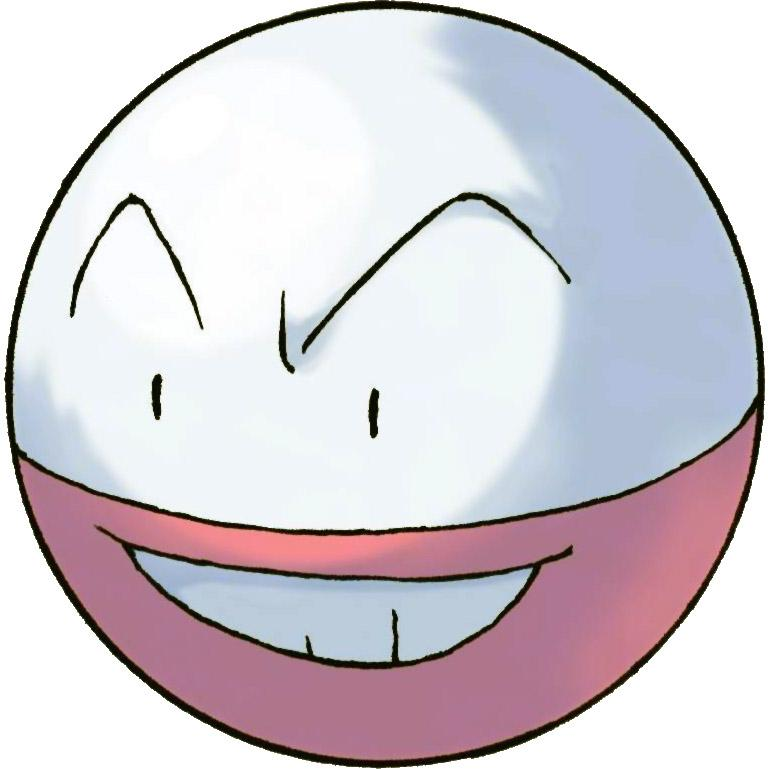

In [32]:
processor = AutoProcessor.from_pretrained(clip_model_name)
tokenizer = AutoTokenizer.from_pretrained(phi_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_tokens('<question-answer>')

row = df.iloc[3]
image_bytes = row['images'][0]['bytes']
img = Image.open(io.BytesIO(image_bytes))
img

In [33]:
image_processed = processor(images=img, return_tensors="pt")['pixel_values']
image_processed = image_processed.squeeze(0)

input_ids = tokenizer(
    f"Instruct: {row['messages'][0]['content']}<question-answer>\n\nOutput:",
    return_tensors="pt",
    return_attention_mask=False
)['input_ids']

print(f"Actual Answer:{row['messages'][1]['content']}")

Actual Answer:A friendly, smiling white orb with a rosy blush and closed eyes expresses contentment and happiness.


In [34]:
images = processor(images=img, return_tensors="pt")

clip_outputs = MModalGPT.clip_model(**images)

image_embeds = clip_outputs.last_hidden_state[:, 1:, :]  # CLS 토큰 제외
projected_image_embeds = MModalGPT.projection(image_embeds).to(torch.float16)  # 이미지 임베딩 프로젝션
generated_ids = input_ids

for _ in range(50):
    # 각 반복에서 projected_image_embeds와 generated_ids를 사용하여 combined_embeddings 생성
    input_embeddings = MModalGPT.text_model.model.embed_tokens(generated_ids)
    input_embeddings = input_embeddings.to(torch.float16)  # 텍스트 임베딩을 float16로 변환
    combined_embeddings = torch.cat((projected_image_embeds, input_embeddings), dim=1)

    outputs = MModalGPT.text_model(inputs_embeds=combined_embeddings).logits
    next_token_logits = outputs[:, -1, :]  # 마지막 토큰의 로짓
    next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)  # 다음 토큰 선택

    generated_ids = torch.cat((generated_ids, next_token_id), dim=1)  # 생성된 토큰 추가

    if next_token_id == MModalGPT.EOS_TOKEN_ID:
        break

generated_text = MModalGPT.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

generated_text.split("<question-answer>")[1]

'\n\nOutput: The creature had a sleek, elegant appearance with a mischievous glint in its eyes. It had a sleek, elegant appearance with a mischievous glint in its eyes.\n'